Question 1 

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

Taken label using 

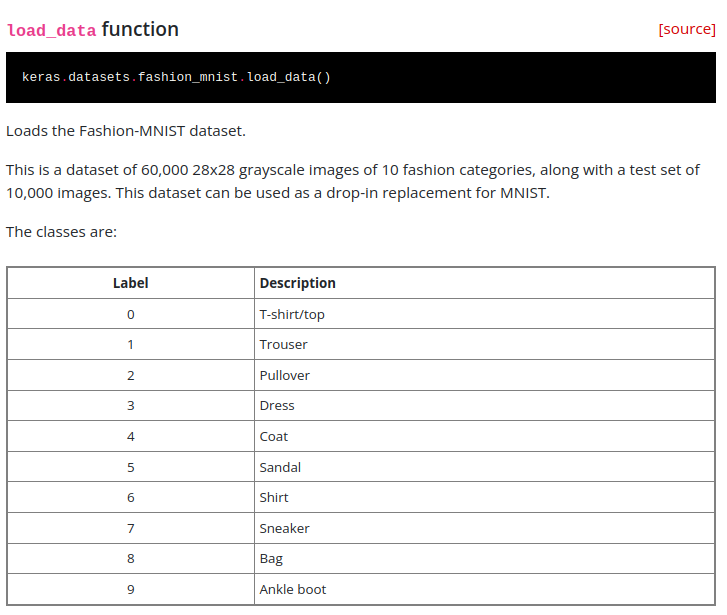


2025-03-17 21:50:28.576368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742228428.590216 1671553 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742228428.594506 1671553 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 21:50:28.611095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


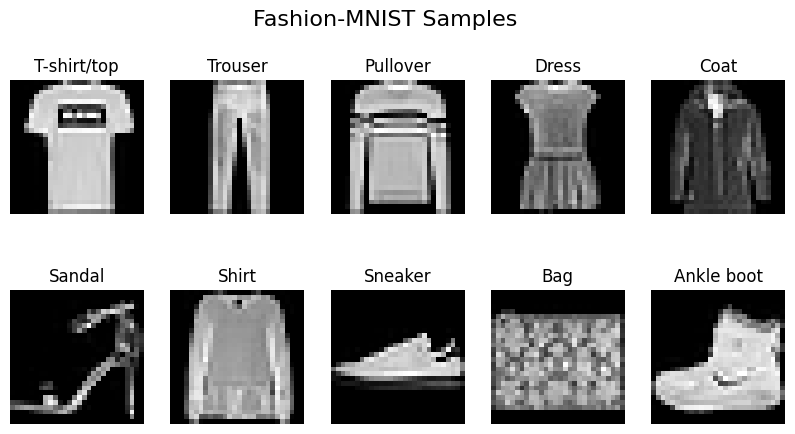

In [1]:

import wandb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.datasets import fashion_mnist


(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()


# identified classnames in keras website 

class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]


sample_images = []

for i in range(10):  # 10 classes in Fashion MNIST
    index = np.where(train_labels == i)[0][0]  # Find the first occurrence of each class
    sample_images.append(train_images[index])
    # sample_labels.append(class_names[i])
    
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle("Fashion-MNIST Samples", fontsize=16)

for ax, img, label in zip(axes.flat, sample_images, class_names):
    ax.imshow(img, cmap='gray')  # Display grayscale image
    ax.set_title(label)  # Set class name as title
    ax.axis("off")  # Hide axes

# # Printing via wandb.ai
# wandb.login()
    
# wandb.init(project="fashion_mnist_sweep",entity="ch24s016-iitm",name='sample images category')

# wandb.log({"Image from each class": [wandb.Image(image, caption=caption) for image, caption in zip(sample_images, class_names)]})



Question 2 

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [2]:
# DATA PREPROCESSING

# Load Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

print(train_images.shape)
print(test_images.shape)

# Normalize pixel values (0-255) -> (0-1)

train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0


train_images_splitted = train_images[:54000]


# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_splitted = one_hot_encode(train_labels[:54000])
test_labels = one_hot_encode(test_labels)

val_images = train_images[54000:] # 10% from training dataset is 6000 data point taken as validation dataset from training
val_labels = one_hot_encode(train_labels[54000:]) # 10% from training dataset labels


# all shapes of train , validation and testing datasets 
print('the shape of training images and its training labels',train_images_splitted.shape,len(train_labels_splitted))
print('the shape of validation images and its validation labels',val_images.shape,len(val_labels))
print('the shape of testing images and its testing labels',test_images.shape,len(test_labels))

(60000, 28, 28)
(10000, 28, 28)
the shape of training images and its training labels (54000, 784) 54000
the shape of validation images and its validation labels (6000, 784) 6000
the shape of testing images and its testing labels (10000, 784) 10000


In [3]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_neurons, hidden_layers, output_neurons):
        
        self.layers = [input_neurons] + hidden_layers + [output_neurons]
        self.weights = {}
        self.biases = {}

        # Initialize weights and biases
        for i in range(len(self.layers) - 1):
            self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
            self.biases[i] = np.zeros((1, self.layers[i+1]))


    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)

    def forward(self, X):
        self.activations = {}
        self.z_values = {}

        # Input Layer
        self.activations[0] = X

        # Hidden Layers
        for i in range(len(self.layers) - 2):
            self.z_values[i] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            self.activations[i+1] = self.relu(self.z_values[i])

        # Output Layer (Softmax)
        last_layer = len(self.layers) - 2
        self.z_values[last_layer] = np.dot(self.activations[last_layer], self.weights[last_layer]) + self.biases[last_layer]
        self.activations[last_layer+1] = self.softmax(self.z_values[last_layer])

        return self.activations[last_layer+1]

    def train(self, X):
        activations = self.forward(X)
        print('output of feed forward after passing whole network of one data point is ',activations[0])

# Example Usage:

hidden_layers = [128, 64]

# Initialize model
model = NeuralNetwork(input_neurons=784, hidden_layers=hidden_layers, output_neurons=10)

# print('the size of training dataset is',train_images.shape)
# print('the size of training dataset is',test_images.shape)

# Train (Assume train_images is your training data and train_labels is one-hot encoded labels)
model.train(train_images_splitted)


output of feed forward after passing whole network of one data point is  [0.0999734  0.10006911 0.09999212 0.10008137 0.0998383  0.10002505
 0.10007554 0.09992282 0.10006682 0.09995547]


Question 3

Implement the backpropagation algorithm with support for the following optimisation functions

sgd
momentum based gradient descent
nesterov accelerated gradient descent
rmsprop
adam
nadam
(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

Epoch 1/10 - Train Loss: 9.8274, Train Acc: 0.7798, Val Loss: 0.4226, Val Acc: 0.8497
Epoch 2/10 - Train Loss: 6.2504, Train Acc: 0.8639, Val Loss: 0.3659, Val Acc: 0.8680
Epoch 3/10 - Train Loss: 5.6689, Train Acc: 0.8744, Val Loss: 0.3469, Val Acc: 0.8710
Epoch 4/10 - Train Loss: 5.3111, Train Acc: 0.8842, Val Loss: 0.3304, Val Acc: 0.8780
Epoch 5/10 - Train Loss: 5.0137, Train Acc: 0.8904, Val Loss: 0.3430, Val Acc: 0.8720
Epoch 6/10 - Train Loss: 4.8715, Train Acc: 0.8937, Val Loss: 0.3412, Val Acc: 0.8793
Epoch 7/10 - Train Loss: 4.6797, Train Acc: 0.8974, Val Loss: 0.3155, Val Acc: 0.8832
Epoch 8/10 - Train Loss: 4.5206, Train Acc: 0.9003, Val Loss: 0.3281, Val Acc: 0.8798
Epoch 9/10 - Train Loss: 4.4055, Train Acc: 0.9046, Val Loss: 0.3172, Val Acc: 0.8860
Epoch 10/10 - Train Loss: 4.2067, Train Acc: 0.9084, Val Loss: 0.3155, Val Acc: 0.8883


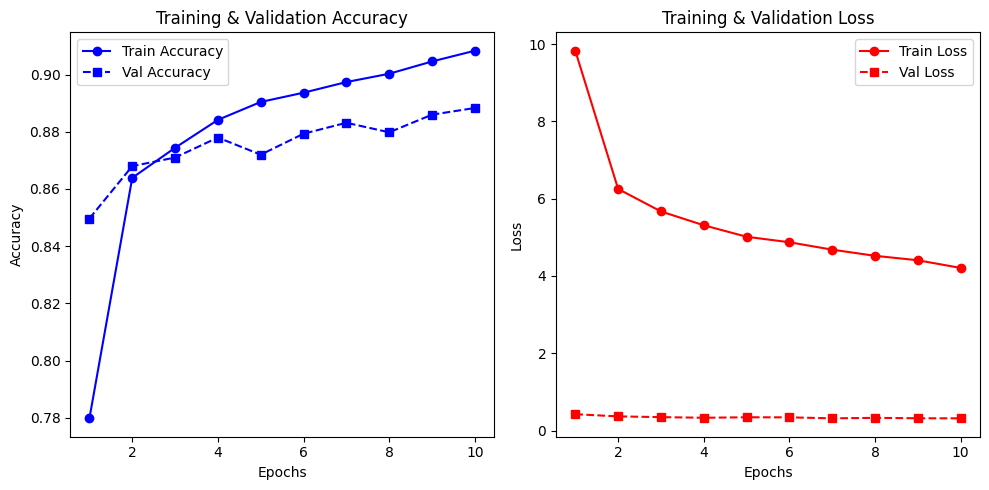

(np.float64(0.9083703703703704),
 np.float64(0.8883333333333333),
 np.float64(4.206658245140104),
 np.float64(0.31549912328060065))

In [4]:
import numpy as np

class NeuralNetwork:
    def __init__(self, input_neurons, hidden_layers, output_neurons, init_wb_method, optimizer, activation, learning_rate, weight_decay, beta1, beta2, epsilon=1e-8):
        self.layers = [input_neurons] + hidden_layers + [output_neurons]
        self.weights = {}
        self.biases = {}
        self.beta1 = beta1
        self.beta2 = beta2
        self.init_wb_method = init_wb_method
        self.epsilon = epsilon
        self.activation = activation
        self.weight_decay = weight_decay

        if init_wb_method == 'random':
            for i in range(len(self.layers) - 1):
                self.weights[i] = np.random.randn(self.layers[i], self.layers[i+1]) * 0.01
                self.biases[i] = np.zeros((1, self.layers[i+1]))

        elif init_wb_method == 'xavier':
            for i in range(len(self.layers) - 1):
                r = np.sqrt(6.0 / (self.layers[i] + self.layers[i+1]))
                self.weights[i] = np.random.uniform(-r, r, (self.layers[i], self.layers[i+1]))
                self.biases[i] = np.zeros((1, self.layers[i+1]))

        # Initialize optimizer parameters
        self.optimizer = optimizer
        self.learning_rate = learning_rate

        num_layers = len(self.layers) - 1  # Number of weight layers

        # For Adam, Nadam, and RMSprop
        self.m_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.v_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.m_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}
        self.v_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}
        
        # For Adam/Nadam timestep tracking
        self.t = 0

        # For Momentum and Nesterov
        self.velocity_w = {i: np.zeros_like(self.weights[i]) for i in range(num_layers)}
        self.velocity_b = {i: np.zeros_like(self.biases[i]) for i in range(num_layers)}


    # LIST OF ACTIVATION FUNCTIONS 

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def softmax_derivative(self, output, y):
        return output - y
    
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        sig = self.sigmoid(x)
        return sig * (1 - sig)

    def tanh(self, x):
        return np.tanh(x)

    def tanh_derivative(self, x):
        return 1 - np.tanh(x) ** 2

    def forward(self, X):
        self.activations = {}
        self.z_values = {}

        # Input Layer
        self.activations[0] = X

        # Hidden Layers
        for i in range(len(self.layers) - 2):
            self.z_values[i] = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            if self.activation == 'relu':
                self.activations[i+1] = self.relu(self.z_values[i])
            elif self.activation == 'sigmoid':
                self.activations[i+1] = self.sigmoid(self.z_values[i])
            elif self.activation == 'tanh':
                self.activations[i+1] = self.tanh(self.z_values[i])

        # Output Layer (Softmax)
        last_layer = len(self.layers) - 2
        self.z_values[last_layer] = np.dot(self.activations[last_layer], self.weights[last_layer]) + self.biases[last_layer]
        self.activations[last_layer+1] = self.softmax(self.z_values[last_layer])

        return self.activations[last_layer+1]
    
    def backward(self, X, y):
        m = X.shape[0]

        # Compute gradient for the output layer
        output = self.activations[len(self.layers) - 1]
        delta = self.softmax_derivative(output, y) / m

        # Backpropagate through the layers
        gradients_w = {}
        gradients_b = {}

        for i in reversed(range(len(self.layers) - 1)):
            gradients_w[i] = np.dot(self.activations[i].T, delta)
            gradients_b[i] = np.sum(delta, axis=0, keepdims=True)

            if i != 0:
                if self.activation == 'relu':
                    delta = np.dot(delta, self.weights[i].T) * self.relu_derivative(self.z_values[i - 1])
                elif self.activation == 'sigmoid':
                    delta = np.dot(delta, self.weights[i].T) * self.sigmoid_derivative(self.z_values[i - 1])
                elif self.activation == 'tanh':
                    delta = np.dot(delta, self.weights[i].T) * self.tanh_derivative(self.z_values[i - 1])

        return gradients_w, gradients_b
    
    def optimization_functions(self, gradients_w, gradients_b):
        num_layers = len(self.layers) - 1

        if self.optimizer == 'sgd':
            for i in range(num_layers):
                self.weights[i] -= self.learning_rate * (gradients_w[i] + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * gradients_b[i]  # No weight decay for biases

        elif self.optimizer == 'momentum':
            beta = 0.9
            for i in range(num_layers):
                self.velocity_w[i] = beta * self.velocity_w[i] + (1 - beta) * gradients_w[i]
                self.velocity_b[i] = beta * self.velocity_b[i] + (1 - beta) * gradients_b[i]

                self.weights[i] -= self.learning_rate * (self.velocity_w[i] + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * self.velocity_b[i]  # No weight decay for biases

        elif self.optimizer == 'nesterov':
            beta = 0.9
            for i in range(num_layers):
                prev_velocity_w = self.velocity_w[i]
                prev_velocity_b = self.velocity_b[i]

                self.velocity_w[i] = beta * prev_velocity_w + (1 - beta) * gradients_w[i]
                self.velocity_b[i] = beta * prev_velocity_b + (1 - beta) * gradients_b[i]

                self.weights[i] -= self.learning_rate * ((gradients_w[i] + beta * prev_velocity_w) + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * (gradients_b[i] + beta * prev_velocity_b)  # No weight decay for biases

        elif self.optimizer == 'rmsprop':
            decay_rate = 0.9
            epsilon = 1e-8
            for i in range(num_layers):
                self.m_w[i] = decay_rate * self.m_w[i] + (1 - decay_rate) * gradients_w[i]**2
                self.m_b[i] = decay_rate * self.m_b[i] + (1 - decay_rate) * gradients_b[i]**2

                self.weights[i] -= self.learning_rate * (gradients_w[i] / (np.sqrt(self.m_w[i]) + epsilon) + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * (gradients_b[i] / (np.sqrt(self.m_b[i]) + epsilon))  # No weight decay for biases

        elif self.optimizer == 'adam':
            self.t += 1
            for i in range(num_layers):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * gradients_w[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * gradients_b[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * gradients_b[i]**2

                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)

                self.weights[i] -= self.learning_rate * (m_w_hat / (np.sqrt(v_w_hat) + self.epsilon) + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * (m_b_hat / (np.sqrt(v_b_hat) + self.epsilon))  # No weight decay for biases

        elif self.optimizer == 'nadam':
            self.t += 1
            for i in range(num_layers):
                self.m_w[i] = self.beta1 * self.m_w[i] + (1 - self.beta1) * gradients_w[i]
                self.v_w[i] = self.beta2 * self.v_w[i] + (1 - self.beta2) * gradients_w[i]**2
                self.m_b[i] = self.beta1 * self.m_b[i] + (1 - self.beta1) * gradients_b[i]
                self.v_b[i] = self.beta2 * self.v_b[i] + (1 - self.beta2) * gradients_b[i]**2

                m_w_hat = self.m_w[i] / (1 - self.beta1**self.t)
                v_w_hat = self.v_w[i] / (1 - self.beta2**self.t)
                m_b_hat = self.m_b[i] / (1 - self.beta1**self.t)
                v_b_hat = self.v_b[i] / (1 - self.beta2**self.t)

                self.weights[i] -= self.learning_rate * ((self.beta1 * m_w_hat + (1 - self.beta1) * gradients_w[i]) / (np.sqrt(v_w_hat) + self.epsilon) + self.weight_decay * self.weights[i])
                self.biases[i] -= self.learning_rate * ((self.beta1 * m_b_hat + (1 - self.beta1) * gradients_b[i]) / (np.sqrt(v_b_hat) + self.epsilon))  # No weight decay for biases
                    
            
    def train(self, X, y, epochs, batch_size, X_val, y_val,loss_function = 'squared_error', wb_log=True,plots=False):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            # Shuffle the data
            indices = np.random.permutation(len(X))
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            total_loss = 0
            correct_preds_train = 0

            for i in range(0, len(X), batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                predictions = self.forward(X_batch)

                # Compute loss (Cross-entropy loss)
                
                if loss_function == "cross_entropy":
                    loss = -np.sum(y_batch * np.log(predictions + 1e-8)) / len(y_batch)  # Avoid log(0)
                elif loss_function == "squared_error":
                    loss = np.sum((y_batch - predictions) ** 2)
                total_loss += loss

                # Compute accuracy for training batch
                y_pred_labels = np.argmax(predictions, axis=1)
                y_true_labels = np.argmax(y_batch, axis=1)
                correct_preds_train += np.sum(y_pred_labels == y_true_labels)

                # Backward pass
                gradients_w, gradients_b = self.backward(X_batch, y_batch)

                # Update weights
                self.optimization_functions(gradients_w, gradients_b)

            # Compute training loss and accuracy
            avg_train_loss = total_loss / (len(X) / batch_size)
            train_losses.append(avg_train_loss)
            train_acc = correct_preds_train / len(X)
            train_accuracies.append(train_acc)

            # Compute validation loss and accuracy
            if X_val is not None and y_val is not None:
                val_predictions = self.forward(X_val)
                val_loss = -np.sum(y_val * np.log(val_predictions + 1e-8)) / len(y_val)
                val_losses.append(val_loss)

                # Compute validation accuracy
                val_pred_labels = np.argmax(val_predictions, axis=1)
                val_true_labels = np.argmax(y_val, axis=1)
                val_acc = np.sum(val_pred_labels == val_true_labels) / len(y_val)
                val_accuracies.append(val_acc)


                if wb_log:
                     wandb.log({'train_acc': train_acc, 'val_acc': val_acc, 'train_loss': avg_train_loss, 'val_loss': val_loss})

                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
            else:
                print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")


        epochs_range = np.arange(1, epochs + 1)

        if(plots):
            plt.figure(figsize=(10, 5))

            # Plot accuracy
            plt.subplot(1, 2, 1)
            plt.plot(epochs_range, train_accuracies, "bo-", label="Train Accuracy")
            plt.plot(epochs_range, val_accuracies, "bs--", label="Val Accuracy")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.title("Training & Validation Accuracy")
            plt.legend()

            # Plot loss
            plt.subplot(1, 2, 2)
            plt.plot(epochs_range, train_losses, "ro-", label="Train Loss")
            plt.plot(epochs_range, val_losses, "rs--", label="Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.title("Training & Validation Loss")
            plt.legend()

            plt.tight_layout()
            plt.show()

        

        return train_acc, val_acc, avg_train_loss ,val_loss


            
    def predict(self, X_test):
        predictions = self.forward(X_test)
        # print(predictions)
        # y_pred_labels = np.argmax(predictions, axis=1)
        return predictions
        

# Example Usage:

hidden_layers = [128, 64]
    
# Initialize model
model = NeuralNetwork(input_neurons=784, hidden_layers=hidden_layers, output_neurons=10,init_wb_method='random',activation='tanh',learning_rate=0.001,optimizer='nadam',weight_decay=0.0005,beta1=0.9,beta2=0.99)

# Train (Assume train_images is your training data and train_labels is one-hot encoded labels)
model.train(train_images_splitted,train_labels_splitted,epochs=10,batch_size=32,X_val=val_images,y_val=val_labels,plots=True,wb_log=False)

Question 4

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

number of epochs: 5, 10
number of hidden layers: 3, 4, 5
size of every hidden layer: 32, 64, 128
weight decay (L2 regularisation): 0, 0.0005, 0.5
learning rate: 1e-3, 1 e-4
optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
batch size: 16, 32, 64
weight initialisation: random, Xavier
activation functions: sigmoid, tanh, ReLU
wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [5]:
import wandb

sweep_config = {
    "method": "bayes",  # Use Bayesian optimization for efficient search
    "metric": {"name": "val_loss", "goal": "minimize"},  # Minimize validation loss
    "parameters": {
        "epochs": {"values": [5, 10]},
        "hidden_layers": {"values": [3, 4, 5]},
        "hidden_size": {"values": [32, 64, 128]},
        "weight_decay": {"values": [0, 0.0005, 0.5]},
        "learning_rate": {"values": [1e-3, 1e-4]},
        "optimizer": {"values": ["sgd", "momentum", "nesterov", "rmsprop", "adam", "nadam"]},
        "batch_size": {"values": [16, 32, 64]},
        "weight_init": {"values": ["random", "xavier"]},
        "activation": {"values": ["sigmoid", "tanh", "relu"]}
    }
}

def train():
   run = wandb.init()  # Initialize W&B inside function
   config = wandb.config

   wandb.run.name = f"{config.weight_init}_{config.optimizer}_{config.activation}_bs_{config.batch_size}_layers_{config.hidden_layers}_neurons_{config.hidden_size}"

   # Initialize the model
   model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[config.hidden_size] * config.hidden_layers,
       output_neurons=10,
       optimizer=config.optimizer,
       learning_rate=config.learning_rate,
       init_wb_method=config.weight_init,
       weight_decay = config.weight_decay,
       activation=config.activation,
       beta1=0.9,
       beta2=0.999
   )

   # Train & Evaluate
   train_acc, val_acc, train_loss, val_loss = model.train(train_images_splitted, train_labels_splitted, config.epochs, config.batch_size, val_images, val_labels,loss_function='cross_entropy',plots=False,wb_log=True)

   # Log metrics
   


# Initialize and run the sweep
sweep_id = wandb.sweep(sweep_config, project="fashion_mnist_sweep")
wandb.agent(sweep_id, function=train, count=3)  # Run 30 trials

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: tg9m3hio
Sweep URL: https://wandb.ai/ch24s016-iitm/fashion_mnist_sweep/sweeps/tg9m3hio


wandb: Agent Starting Run: dj64bc0s with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier
wandb: Currently logged in as: ch24s016 (ch24s016-iitm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch 1/10 - Train Loss: 57.8924, Train Acc: 0.0993, Val Loss: 2.2093, Val Acc: 0.1630
Epoch 2/10 - Train Loss: 54.9261, Train Acc: 0.2556, Val Loss: 2.0177, Val Acc: 0.3373
Epoch 3/10 - Train Loss: 51.9957, Train Acc: 0.4067, Val Loss: 1.8560, Val Acc: 0.4575
Epoch 4/10 - Train Loss: 49.1504, Train Acc: 0.5028, Val Loss: 1.7169, Val Acc: 0.5320
Epoch 5/10 - Train Loss: 46.5033, Train Acc: 0.5565, Val Loss: 1.5976, Val Acc: 0.5788
Epoch 6/10 - Train Loss: 44.1128, Train Acc: 0.5883, Val Loss: 1.4955, Val Acc: 0.6087
Epoch 7/10 - Train Loss: 41.9782, Train Acc: 0.6119, Val Loss: 1.4079, Val Acc: 0.6267
Epoch 8/10 - Train Loss: 40.0710, Train Acc: 0.6260, Val Loss: 1.3322, Val Acc: 0.6430
Epoch 9/10 - Train Loss: 38.3656, Train Acc: 0.6389, Val Loss: 1.2665, Val Acc: 0.6538
Epoch 10/10 - Train Loss: 36.8363, Train Acc: 0.6493, Val Loss: 1.2092, Val Acc: 0.6613


train_acc,▁▃▅▆▇▇████
train_loss,█▇▆▅▄▃▃▂▂▁
val_acc,▁▃▅▆▇▇████
val_loss,█▇▆▅▄▃▂▂▁▁
train_acc,0.6493
train_loss,36.83634
val_acc,0.66133
val_loss,1.20918


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uzfmir5d with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	hidden_layers: 3
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


Epoch 1/5 - Train Loss: 28.8000, Train Acc: 0.0886, Val Loss: 2.3026, Val Acc: 0.0925
Epoch 2/5 - Train Loss: 28.8000, Train Acc: 0.1014, Val Loss: 2.3026, Val Acc: 0.0925
Epoch 3/5 - Train Loss: 28.8000, Train Acc: 0.1010, Val Loss: 2.3026, Val Acc: 0.0925
Epoch 4/5 - Train Loss: 28.8000, Train Acc: 0.1010, Val Loss: 2.3026, Val Acc: 0.0925
Epoch 5/5 - Train Loss: 28.8000, Train Acc: 0.1008, Val Loss: 2.3026, Val Acc: 0.0925


train_acc,▁████
train_loss,█▆▃▂▁
val_acc,▁▁▁▁▁
val_loss,▁▂▄▆█
train_acc,0.10083
train_loss,28.79998
val_acc,0.0925
val_loss,2.3026


wandb: Agent Starting Run: yv285u5u with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	hidden_layers: 5
wandb: 	hidden_size: 32
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0
wandb: 	weight_init: random


Epoch 1/10 - Train Loss: 21.3297, Train Acc: 0.4188, Val Loss: 0.9583, Val Acc: 0.5900
Epoch 2/10 - Train Loss: 14.3037, Train Acc: 0.6432, Val Loss: 0.8279, Val Acc: 0.6813
Epoch 3/10 - Train Loss: 13.2608, Train Acc: 0.6787, Val Loss: 0.7917, Val Acc: 0.6935
Epoch 4/10 - Train Loss: 12.6162, Train Acc: 0.7038, Val Loss: 0.7537, Val Acc: 0.7202
Epoch 5/10 - Train Loss: 11.9988, Train Acc: 0.7224, Val Loss: 0.7411, Val Acc: 0.7143
Epoch 6/10 - Train Loss: 11.3004, Train Acc: 0.7428, Val Loss: 0.6851, Val Acc: 0.7497
Epoch 7/10 - Train Loss: 10.7403, Train Acc: 0.7586, Val Loss: 0.6593, Val Acc: 0.7617
Epoch 8/10 - Train Loss: 10.3426, Train Acc: 0.7653, Val Loss: 0.6519, Val Acc: 0.7625
Epoch 9/10 - Train Loss: 10.0759, Train Acc: 0.7709, Val Loss: 0.6308, Val Acc: 0.7718
Epoch 10/10 - Train Loss: 9.8423, Train Acc: 0.7769, Val Loss: 0.6177, Val Acc: 0.7763


train_acc,▁▅▆▇▇▇████
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▅▄▄▂▂▂▁▁
train_acc,0.77685
train_loss,9.84231
val_acc,0.77633
val_loss,0.61773


Question 5 (5 marks)
We would like to see the best accuracy on the validation set across all the models that you train.

wandb automatically generates this plot which summarises the test accuracy of all the models that you tested. Please paste this plot below using the "Add Panel to Report" feature

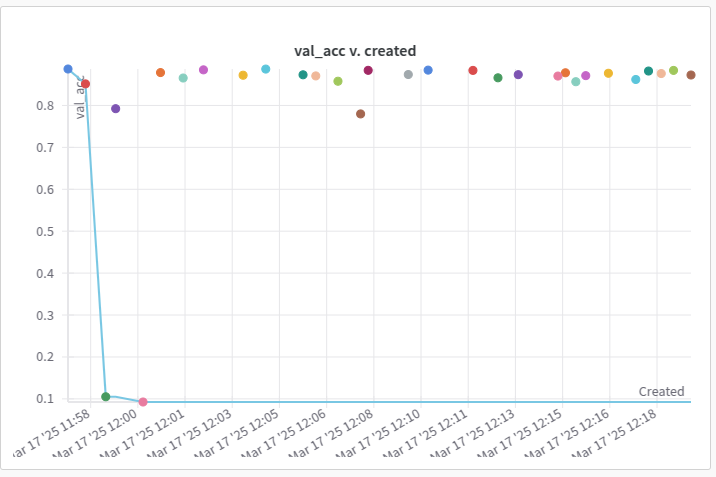

Question 6 (20 Marks)


Based on the different experiments that you have run we want you to make some inferences about which configurations worked and which did not.

Here again, wandb automatically generates a "Parallel co-ordinates plot" and a "correlation summary" as shown below. Learn about a "Parallel co-ordinates plot" and how to read it.

By looking at the plots that you get, write down some interesting observations (simple bullet points but should be insightful). You can also refer to the plot in Question 5 while writing these insights. For example, in the above sample plot there are many configurations which give less than 65% accuracy. I would like to zoom into those and see what is happening.

I would also like to see a recommendation for what configuration to use to get close to 95% accuracy.

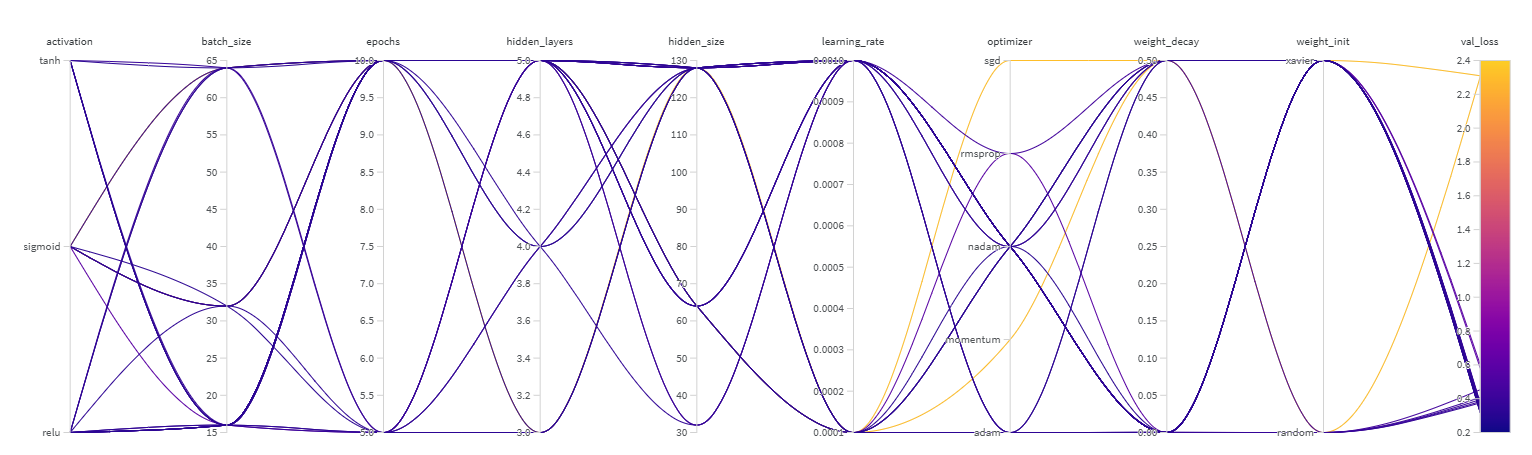

Question 7 (10 Marks)



For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<Run ch24s016-iitm/fashion_mnist_sweep/fb9d9r7d (finished)>
Best run ID: fb9d9r7d, Val Accuracy: 0.8856666666666667
the best model parameters are {'epochs': 10, 'optimizer': 'nadam', 'activation': 'tanh', 'batch_size': 32, 'hidden_size': 128, 'weight_init': 'xavier', 'weight_decay': 0.0005, 'hidden_layers': 4, 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 7.6313, Train Acc: 0.8304, Val Loss: 0.3852, Val Acc: 0.8592
Epoch 2/10 - Train Loss: 6.1044, Train Acc: 0.8655, Val Loss: 0.3430, Val Acc: 0.8733
Epoch 3/10 - Train Loss: 5.6477, Train Acc: 0.8754, Val Loss: 0.3456, Val Acc: 0.8705
Epoch 4/10 - Train Loss: 5.2927, Train Acc: 0.8838, Val Loss: 0.3359, Val Acc: 0.8810
Epoch 5/10 - Train Loss: 5.0102, Train Acc: 0.8906, Val Loss: 0.3404, Val Acc: 0.8765
Epoch 6/10 - Train Loss: 4.8662, Train Acc: 0.8930, Val Loss: 0.3318, Val Acc: 0.8805
Epoch 7/10 - Train Loss: 4.6987, Train Acc: 0.8964, Val Loss: 0.3563, Val Acc: 0.8685
Epoch 8/10 - Train Loss: 4.5190, Train Acc: 0.9025, Val Loss: 

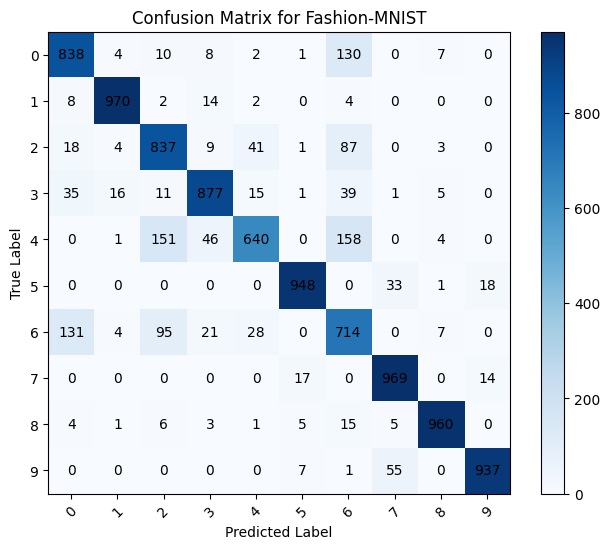

<Figure size 640x480 with 0 Axes>

In [14]:

wandb.login()
wandb.init()
wandb.init(project="fashion_mnist_sweep",entity="ch24s016-iitm",name='sample images category')
api = wandb.Api()

# Fetch all runs in the sweep
sweep_runs = api.sweep(f"ch24s016-iitm/fashion_mnist_sweep/2xv177pr").runs

# Find the best model based on validation accuracy
best_run = max(sweep_runs, key=lambda run: run.summary.get("val_acc", 0))

print(best_run)

print(f"Best run ID: {best_run.id}, Val Accuracy: {best_run.summary.get('val_acc', 0)}")

print('the best model parameters are',best_run.config)


model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[best_run.config['hidden_size']] * best_run.config['hidden_layers'],
       output_neurons=10,
       optimizer=best_run.config['optimizer'],
       learning_rate=best_run.config['learning_rate'],
       init_wb_method=best_run.config['weight_init'],
       weight_decay = best_run.config['weight_decay'],
       activation=best_run.config['activation'],
       beta1=0.9,
       beta2=0.999
   )

model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,plots=False,wb_log=True)

y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)
test_accuracy = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset is ',test_accuracy)

# Number of classes in Fashion-MNIST
num_classes = 10

# Initialize confusion matrix with zeros
confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)

# Populate the confusion matrix
for true, pred in zip(y_true_labels, y_pred):
    confusion_matrix[true, pred] += 1


    
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(confusion_matrix, cmap="Blues")

# Add color bar
plt.colorbar(cax)

# Set labels
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(np.arange(num_classes))
ax.set_yticklabels(np.arange(num_classes))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add text annotations inside the cells
for i in range(num_classes):
    for j in range(num_classes):
        ax.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="black")
wandb.run.name = 'confusion matrix'
# Set title
ax.set_title("Confusion Matrix for Fashion-MNIST")
image_path = "confusion_matrix.png"
plt.savefig(image_path, bbox_inches="tight")

# ✅ Log the saved image to W&B
wandb.log({"Confusion Matrix": wandb.Image(image_path)})
# wandb.log({"Confusion Matrix": wandb.Image(plt)})
# Show plot
plt.show()

image_path = "confusion_matrix.png"
plt.savefig(image_path, bbox_inches="tight")
plt.close(fig)  





To Verify that our confusion Matrix is correct we are going to compare the accuracy with computed confusion matrix Vs our Manually Computed Accuracy

In [7]:
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(test_labels, axis=1)
test_accuracy = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset is ',test_accuracy)


# Print the confusion matrix in a readable format
print("Confusion Matrix:")
for row in confusion_matrix:
    print(" ".join(f"{val:5d}" for val in row))
    
correct_predictions = sum(confusion_matrix[i][i] for i in range(num_classes))

# Compute total predictions (sum of all elements)
total_predictions = sum(sum(row) for row in confusion_matrix)

# Calculate accuracy
accuracy = correct_predictions / total_predictions

# Print accuracy
print("Computed Test Accuracy:", accuracy)

the accuracy of test dataset is  0.8741
Confusion Matrix:
  823     1    19    54     6     2    83     0    12     0
    1   963     8    22     3     0     3     0     0     0
   11     2   764    22   149     0    48     0     4     0
   11    11    14   931    22     0     7     0     4     0
    0     0    69    54   834     0    37     0     6     0
    1     0     0     1     0   968     0    20     1     9
  137     2   115    58    79     1   603     0     5     0
    0     0     0     0     0    36     0   927     0    37
    2     0     4     5     2     4     9     2   972     0
    0     0     0     0     0    14     1    29     0   956
Computed Test Accuracy: 0.8741


Question 8 (5 Marks)


In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

Added squared_error in neural network code on 4TH Question Part                
                
    if loss_function == "cross_entropy":
        loss = -np.sum(y_batch * np.log(predictions + 1e-8)) / len(y_batch)  # Avoid log(0)
    elif loss_function == "squared_error":
        loss = np.sum((y_batch - predictions) ** 2) 
    total_loss += loss

On our best model I am going to run the model with both cross entropy and squared error and let compare how accuracies are coming...

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<Run ch24s016-iitm/fashion_mnist_sweep/fb9d9r7d (finished)>
Best run ID: fb9d9r7d, Val Accuracy: 0.8856666666666667
the best model parameters are {'epochs': 10, 'optimizer': 'nadam', 'activation': 'tanh', 'batch_size': 32, 'hidden_size': 128, 'weight_init': 'xavier', 'weight_decay': 0.0005, 'hidden_layers': 4, 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 0.4875, Train Acc: 0.8248, Val Loss: 0.3923, Val Acc: 0.8542
Epoch 2/10 - Train Loss: 0.3652, Train Acc: 0.8670, Val Loss: 0.3974, Val Acc: 0.8475
Epoch 3/10 - Train Loss: 0.3347, Train Acc: 0.8762, Val Loss: 0.3414, Val Acc: 0.8755
Epoch 4/10 - Train Loss: 0.3111, Train Acc: 0.8844, Val Loss: 0.3461, Val Acc: 0.8740
Epoch 5/10 - Train Loss: 0.2953, Train Acc: 0.8904, Val Loss: 0.3256, Val Acc: 0.8788
Epoch 6/10 - Train Loss: 0.2805, Train Acc: 0.8956, Val Loss: 0.3457, Val Acc: 0.8737
Epoch 7/10 - Train Loss: 0.2674, Train Acc: 0.8988, Val Loss: 0.3255, Val Acc: 0.8845
Epoch 8/10 - Train Loss: 0.2563, Train Acc: 0.9031, Val Loss: 

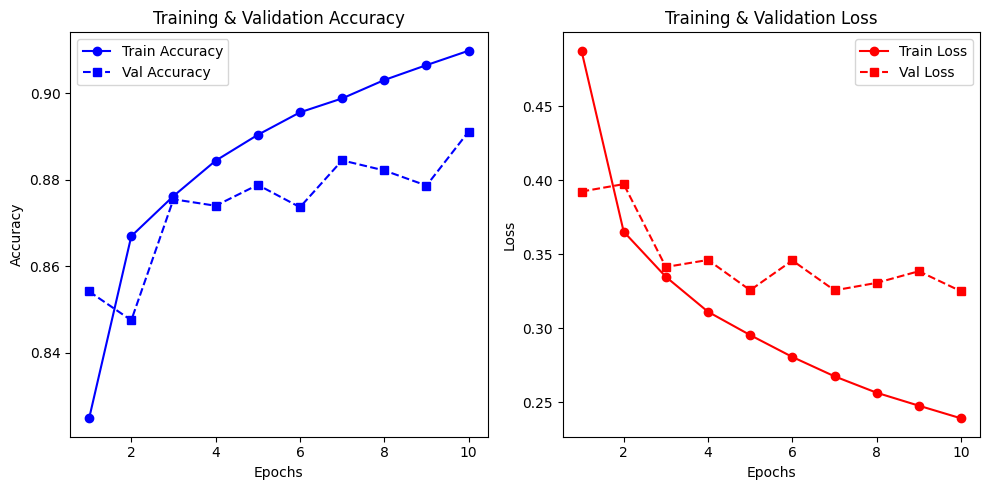

the accuracy of test dataset with Cross Entropy Loss  0.8911666666666667
Epoch 1/10 - Train Loss: 4.0762, Train Acc: 0.9107, Val Loss: 0.3179, Val Acc: 0.8852
Epoch 2/10 - Train Loss: 3.8883, Train Acc: 0.9150, Val Loss: 0.3208, Val Acc: 0.8898
Epoch 3/10 - Train Loss: 3.7628, Train Acc: 0.9179, Val Loss: 0.3505, Val Acc: 0.8830
Epoch 4/10 - Train Loss: 3.7025, Train Acc: 0.9192, Val Loss: 0.3484, Val Acc: 0.8925
Epoch 5/10 - Train Loss: 3.5774, Train Acc: 0.9221, Val Loss: 0.3327, Val Acc: 0.8923
Epoch 6/10 - Train Loss: 3.5160, Train Acc: 0.9230, Val Loss: 0.3341, Val Acc: 0.8895
Epoch 7/10 - Train Loss: 3.4484, Train Acc: 0.9255, Val Loss: 0.3358, Val Acc: 0.8848
Epoch 8/10 - Train Loss: 3.3351, Train Acc: 0.9276, Val Loss: 0.3374, Val Acc: 0.8943
Epoch 9/10 - Train Loss: 3.2561, Train Acc: 0.9299, Val Loss: 0.3515, Val Acc: 0.8870
Epoch 10/10 - Train Loss: 3.1855, Train Acc: 0.9304, Val Loss: 0.3690, Val Acc: 0.8925


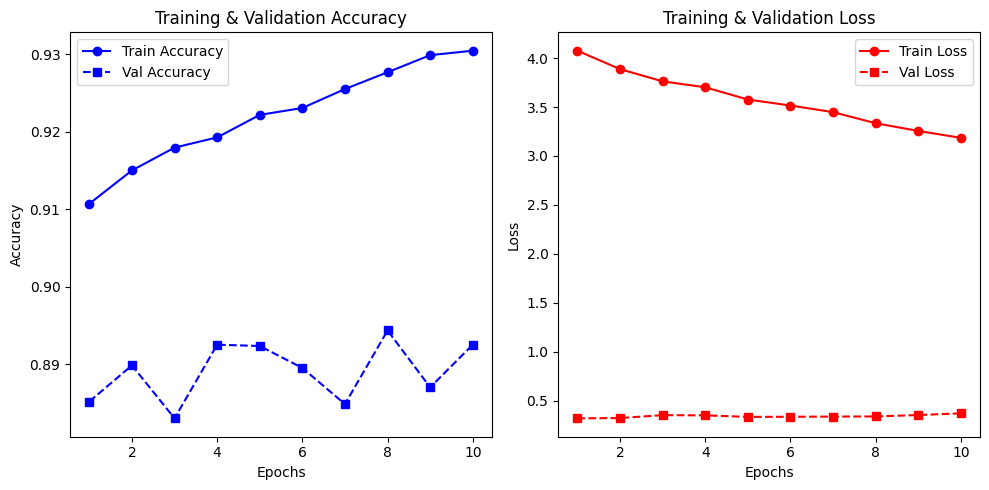

the accuracy of test dataset with Squared Error Loss  0.8925


In [ ]:
wandb.login()
wandb.init()
api = wandb.Api()

# Fetch all runs in the sweep
sweep_runs = api.sweep(f"ch24s016-iitm/fashion_mnist_sweep/2xv177pr").runs

# Find the best model based on validation accuracy
best_run = max(sweep_runs, key=lambda run: run.summary.get("val_acc", 0))

print(best_run)

print(f"Best run ID: {best_run.id}, Val Accuracy: {best_run.summary.get('val_acc', 0)}")

print('the best model parameters are',best_run.config)


model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[best_run.config['hidden_size']] * best_run.config['hidden_layers'],
       output_neurons=10,
       optimizer=best_run.config['optimizer'],
       learning_rate=best_run.config['learning_rate'],
       init_wb_method=best_run.config['weight_init'],
       weight_decay = best_run.config['weight_decay'],
       activation='relu',
       beta1=0.9,
       beta2=0.999
   )

model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,loss_function='cross_entropy',plots=True,wb_log=True)

y_pred = model.predict(val_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(val_labels, axis=1)
test_accuracy_ce = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset with Cross Entropy Loss ',test_accuracy_ce)


model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,loss_function='squared_error',plots=True,wb_log=True)

y_pred = model.predict(val_images)
y_pred = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(val_labels, axis=1)
test_accuracy_se = np.mean(y_pred == y_true_labels)
print('the accuracy of test dataset with Squared Error Loss ',test_accuracy_se)


accuracy_cross_entropy = test_accuracy_ce  # Store accuracy from Cross Entropy
accuracy_squared_error = test_accuracy_se  # Store accuracy from Squared Error

# Labels and values
loss_functions = ['Cross Entropy', 'Squared Error']
accuracies = [accuracy_cross_entropy, accuracy_squared_error]




Question 9 (10 Marks)
Paste a link to your github code for this assignment

https://github.com/Hemnath0075/da6401_assignment1

Question 10 (10 Marks)

Based on your learnings above, give me 3 recommendations for what would work for the MNIST dataset (not Fashion-MNIST). Just to be clear, I am asking you to take your learnings based on extensive experimentation with one dataset and see if these learnings help on another dataset. If I give you a budget of running only 3 hyperparameter configurations as opposed to the large number of experiments you have run above then which 3 would you use and why. Report the accuracies that you obtain using these 3 configurations.

In [20]:
from keras.datasets import mnist

# Load Fashion-MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)
print(test_images.shape)

# Normalize pixel values (0-255) -> (0-1)

train_images = train_images.reshape(train_images.shape[0], -1) / 255.0
test_images = test_images.reshape(test_images.shape[0], -1) / 255.0


train_images_splitted = train_images[:54000]


# One-hot encode labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_splitted = one_hot_encode(train_labels[:54000])
test_labels = one_hot_encode(test_labels)

val_images = train_images[54000:] # 10% from training dataset is 6000 data point taken as validation dataset from training
val_labels = one_hot_encode(train_labels[54000:]) # 10% from training dataset labels

wandb.login()
wandb.init()
wandb.init(project="fashion_mnist_sweep",entity="ch24s016-iitm",name='sample images category')
api = wandb.Api()

# Fetch all runs in the sweep
sweep_runs = api.sweep(f"ch24s016-iitm/fashion_mnist_sweep/2xv177pr").runs

# Find the best model based on validation accuracy
best_run = max(sweep_runs, key=lambda run: run.summary.get("val_acc", 0))

print(best_run)

print(f"Best run ID: {best_run.id}, Val Accuracy: {best_run.summary.get('val_acc', 0)}")

print('the best model parameters are',best_run.config)


model = NeuralNetwork(
       input_neurons=784,
       hidden_layers=[best_run.config['hidden_size']] * best_run.config['hidden_layers'],
       output_neurons=10,
       optimizer=best_run.config['optimizer'],
       learning_rate=best_run.config['learning_rate'],
       init_wb_method=best_run.config['weight_init'],
       weight_decay = best_run.config['weight_decay'],
       activation=best_run.config['activation'],
       beta1=0.9,
       beta2=0.999
   )

model.train(train_images_splitted, train_labels_splitted, best_run.config['epochs'], best_run.config['batch_size'], val_images, val_labels,plots=False,wb_log=True)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


(60000, 28, 28)
(10000, 28, 28)


<Run ch24s016-iitm/fashion_mnist_sweep/fb9d9r7d (finished)>
Best run ID: fb9d9r7d, Val Accuracy: 0.8856666666666667
the best model parameters are {'epochs': 10, 'optimizer': 'nadam', 'activation': 'tanh', 'batch_size': 32, 'hidden_size': 128, 'weight_init': 'xavier', 'weight_decay': 0.0005, 'hidden_layers': 4, 'learning_rate': 0.001}
Epoch 1/10 - Train Loss: 3.6599, Train Acc: 0.9240, Val Loss: 0.1316, Val Acc: 0.9643
Epoch 2/10 - Train Loss: 1.8259, Train Acc: 0.9627, Val Loss: 0.0984, Val Acc: 0.9700
Epoch 3/10 - Train Loss: 1.3532, Train Acc: 0.9725, Val Loss: 0.1110, Val Acc: 0.9670
Epoch 4/10 - Train Loss: 1.0754, Train Acc: 0.9783, Val Loss: 0.0937, Val Acc: 0.9730
Epoch 5/10 - Train Loss: 0.9091, Train Acc: 0.9814, Val Loss: 0.0805, Val Acc: 0.9768
Epoch 6/10 - Train Loss: 0.7367, Train Acc: 0.9845, Val Loss: 0.0927, Val Acc: 0.9750
Epoch 7/10 - Train Loss: 0.5993, Train Acc: 0.9876, Val Loss: 0.1103, Val Acc: 0.9702
Epoch 8/10 - Train Loss: 0.5520, Train Acc: 0.9887, Val Loss: 

(np.float64(0.9917037037037038),
 np.float64(0.9765),
 np.float64(0.4255346634824573),
 np.float64(0.09750537794488028))

In [24]:
wandb.login()
wandb.init()
wandb.init(project="fashion_mnist_sweep",entity="ch24s016-iitm",name='sample images category')
api = wandb.Api()

# Fetch all runs in the sweep
sweep_runs = api.sweep(f"ch24s016-iitm/fashion_mnist_sweep/2xv177pr").runs



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
